In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [3]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 512
image_width = 512

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1 and classname.find("DoubleConv") == 1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetUp_UpSample(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            DoubleConv(in_size, out_size, in_size // 2),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [8]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [10]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

generator_file = "saved_models/generator.pth"
discriminator_file = "saved_models/discriminator.pth"
# initialize weights if the model is not found in the paths
if os.path.exists(generator_file):
    print("Generator Found")
    generator.load_state_dict(torch.load(generator_file, map_location = device))
else:
    generator.apply(weights_init_normal)

                                         
if os.path.exists(discriminator_file):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load(discriminator_file, map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True
Generator Found


In [12]:
# create a dataloader
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 2,
    shuffle = True,
)

val_image_dataloader = img_dataloader.ImageDataset("./data/val/old_image", "./data/val/reconstructed_image", transform)
val_dataloader = DataLoader(
    val_image_dataloader,
    batch_size = 5,
    shuffle = True
)

torch.cuda.empty_cache()

In [13]:
generator_error_file = "generator.csv"
disc_error_file = "discriminator.csv"

total_generator_epochs = 0
try: 
    with open(generator_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_generator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_generator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(generator_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()


total_discriminator_epochs = 0
try: 
    with open(disc_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_discriminator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_discriminator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(disc_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()

for epoch in range(1):
    loss_G_list = np.array([])
    loss_D_list = np.array([])
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
        
        loss_G_list = np.append(loss_G_list,  torch.linalg.norm(loss_G).item())
        loss_D_list = np.append(loss_D_list,  torch.linalg.norm(loss_D).item())
     
    # log into a file
    with open(generator_error_file, "a") as f:
        f.write(f"Generator Error, {torch.linalg.norm(loss_G).item()}, {epoch + total_generator_epochs}\n")
    with open(disc_error_file, "a") as f:
        f.write(f"Discriminator Error, {torch.linalg.norm(loss_D).item()}, {epoch + total_discriminator_epochs}\n")
        
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
            
    torch.cuda.empty_cache()

CSV file found
CSV file found


1it [00:01,  1.62s/it]

Generator Error: 3.69970703125, epoch: 0, itr: 0
Discriminator Error: 0.25866249203681946, epoch: 0, itr: 0


2it [00:02,  1.44s/it]

Generator Error: 4.840636730194092, epoch: 0, itr: 1
Discriminator Error: 0.34841156005859375, epoch: 0, itr: 1


3it [00:04,  1.40s/it]

Generator Error: 5.055781364440918, epoch: 0, itr: 2
Discriminator Error: 0.30449366569519043, epoch: 0, itr: 2


4it [00:05,  1.38s/it]

Generator Error: 2.8592464923858643, epoch: 0, itr: 3
Discriminator Error: 0.2697141170501709, epoch: 0, itr: 3


5it [00:06,  1.36s/it]

Generator Error: 3.2551441192626953, epoch: 0, itr: 4
Discriminator Error: 0.26346898078918457, epoch: 0, itr: 4


6it [00:08,  1.35s/it]

Generator Error: 4.813541889190674, epoch: 0, itr: 5
Discriminator Error: 0.26116880774497986, epoch: 0, itr: 5


7it [00:09,  1.35s/it]

Generator Error: 3.379424571990967, epoch: 0, itr: 6
Discriminator Error: 0.2563652992248535, epoch: 0, itr: 6


8it [00:10,  1.35s/it]

Generator Error: 4.835306644439697, epoch: 0, itr: 7
Discriminator Error: 0.2570123076438904, epoch: 0, itr: 7


9it [00:12,  1.34s/it]

Generator Error: 4.999339580535889, epoch: 0, itr: 8
Discriminator Error: 0.2530818581581116, epoch: 0, itr: 8


10it [00:13,  1.34s/it]

Generator Error: 2.6947994232177734, epoch: 0, itr: 9
Discriminator Error: 0.25216227769851685, epoch: 0, itr: 9


11it [00:15,  1.34s/it]

Generator Error: 4.1898393630981445, epoch: 0, itr: 10
Discriminator Error: 0.25125715136528015, epoch: 0, itr: 10


12it [00:16,  1.34s/it]

Generator Error: 2.9344916343688965, epoch: 0, itr: 11
Discriminator Error: 0.25141066312789917, epoch: 0, itr: 11


13it [00:17,  1.34s/it]

Generator Error: 3.3211255073547363, epoch: 0, itr: 12
Discriminator Error: 0.2514893412590027, epoch: 0, itr: 12


14it [00:19,  1.34s/it]

Generator Error: 2.75177264213562, epoch: 0, itr: 13
Discriminator Error: 0.25087806582450867, epoch: 0, itr: 13


15it [00:20,  1.24s/it]

Generator Error: 3.1154427528381348, epoch: 0, itr: 14
Discriminator Error: 0.2504770755767822, epoch: 0, itr: 14


16it [00:20,  1.02s/it]

Generator Error: 3.6579089164733887, epoch: 0, itr: 15
Discriminator Error: 0.25013965368270874, epoch: 0, itr: 15


17it [00:21,  1.16it/s]

Generator Error: 7.020376205444336, epoch: 0, itr: 16
Discriminator Error: 0.25029057264328003, epoch: 0, itr: 16


18it [00:21,  1.33it/s]

Generator Error: 4.6327290534973145, epoch: 0, itr: 17
Discriminator Error: 0.2506464123725891, epoch: 0, itr: 17


19it [00:22,  1.48it/s]

Generator Error: 3.682778835296631, epoch: 0, itr: 18
Discriminator Error: 0.2520735561847687, epoch: 0, itr: 18


20it [00:22,  1.60it/s]

Generator Error: 4.155453205108643, epoch: 0, itr: 19
Discriminator Error: 0.2542175352573395, epoch: 0, itr: 19


21it [00:23,  1.71it/s]

Generator Error: 3.3946127891540527, epoch: 0, itr: 20
Discriminator Error: 0.25552091002464294, epoch: 0, itr: 20


22it [00:23,  1.79it/s]

Generator Error: 3.352367401123047, epoch: 0, itr: 21
Discriminator Error: 0.25240927934646606, epoch: 0, itr: 21


23it [00:24,  1.84it/s]

Generator Error: 3.122910976409912, epoch: 0, itr: 22
Discriminator Error: 0.2514597177505493, epoch: 0, itr: 22


24it [00:24,  1.88it/s]

Generator Error: 3.200944423675537, epoch: 0, itr: 23
Discriminator Error: 0.2502868175506592, epoch: 0, itr: 23


25it [00:25,  1.91it/s]

Generator Error: 3.077979564666748, epoch: 0, itr: 24
Discriminator Error: 0.2510075569152832, epoch: 0, itr: 24


26it [00:25,  1.94it/s]

Generator Error: 3.911715507507324, epoch: 0, itr: 25
Discriminator Error: 0.25129908323287964, epoch: 0, itr: 25


27it [00:26,  1.95it/s]

Generator Error: 4.385257720947266, epoch: 0, itr: 26
Discriminator Error: 0.2508413791656494, epoch: 0, itr: 26


28it [00:26,  1.97it/s]

Generator Error: 2.4556918144226074, epoch: 0, itr: 27
Discriminator Error: 0.2507741153240204, epoch: 0, itr: 27


29it [00:27,  1.98it/s]

Generator Error: 3.031726360321045, epoch: 0, itr: 28
Discriminator Error: 0.25077956914901733, epoch: 0, itr: 28


30it [00:27,  1.99it/s]

Generator Error: 3.7766213417053223, epoch: 0, itr: 29
Discriminator Error: 0.2511812150478363, epoch: 0, itr: 29


31it [00:28,  1.99it/s]

Generator Error: 3.0765469074249268, epoch: 0, itr: 30
Discriminator Error: 0.25155162811279297, epoch: 0, itr: 30


32it [00:28,  1.99it/s]

Generator Error: 2.6165361404418945, epoch: 0, itr: 31
Discriminator Error: 0.2539098262786865, epoch: 0, itr: 31


33it [00:29,  1.99it/s]

Generator Error: 2.9908974170684814, epoch: 0, itr: 32
Discriminator Error: 0.25478196144104004, epoch: 0, itr: 32


34it [00:29,  1.99it/s]

Generator Error: 2.504363775253296, epoch: 0, itr: 33
Discriminator Error: 0.2540350556373596, epoch: 0, itr: 33


35it [00:30,  1.99it/s]

Generator Error: 3.8158841133117676, epoch: 0, itr: 34
Discriminator Error: 0.2508954405784607, epoch: 0, itr: 34


36it [00:30,  2.00it/s]

Generator Error: 3.275101900100708, epoch: 0, itr: 35
Discriminator Error: 0.2505505681037903, epoch: 0, itr: 35


37it [00:31,  1.98it/s]

Generator Error: 3.204834222793579, epoch: 0, itr: 36
Discriminator Error: 0.24952489137649536, epoch: 0, itr: 36


38it [00:31,  1.98it/s]

Generator Error: 3.0766549110412598, epoch: 0, itr: 37
Discriminator Error: 0.25061649084091187, epoch: 0, itr: 37


39it [00:32,  1.99it/s]

Generator Error: 3.462617874145508, epoch: 0, itr: 38
Discriminator Error: 0.24955277144908905, epoch: 0, itr: 38


40it [00:32,  1.99it/s]

Generator Error: 3.249674081802368, epoch: 0, itr: 39
Discriminator Error: 0.250957727432251, epoch: 0, itr: 39


41it [00:33,  1.99it/s]

Generator Error: 3.3899006843566895, epoch: 0, itr: 40
Discriminator Error: 0.25098299980163574, epoch: 0, itr: 40


42it [00:33,  1.99it/s]

Generator Error: 2.4777534008026123, epoch: 0, itr: 41
Discriminator Error: 0.25152283906936646, epoch: 0, itr: 41


43it [00:34,  1.98it/s]

Generator Error: 2.866863250732422, epoch: 0, itr: 42
Discriminator Error: 0.24962279200553894, epoch: 0, itr: 42


44it [00:34,  1.97it/s]

Generator Error: 3.024606943130493, epoch: 0, itr: 43
Discriminator Error: 0.2496943473815918, epoch: 0, itr: 43


45it [00:35,  1.97it/s]

Generator Error: 2.6319870948791504, epoch: 0, itr: 44
Discriminator Error: 0.24885989725589752, epoch: 0, itr: 44


46it [00:35,  1.97it/s]

Generator Error: 5.141297340393066, epoch: 0, itr: 45
Discriminator Error: 0.2480069398880005, epoch: 0, itr: 45


47it [00:36,  1.97it/s]

Generator Error: 3.843324661254883, epoch: 0, itr: 46
Discriminator Error: 0.24919497966766357, epoch: 0, itr: 46


48it [00:36,  1.97it/s]

Generator Error: 3.724900960922241, epoch: 0, itr: 47
Discriminator Error: 0.2517448961734772, epoch: 0, itr: 47


49it [00:37,  1.97it/s]

Generator Error: 4.346590518951416, epoch: 0, itr: 48
Discriminator Error: 0.2509284019470215, epoch: 0, itr: 48


50it [00:37,  1.98it/s]

Generator Error: 3.660417079925537, epoch: 0, itr: 49
Discriminator Error: 0.25487154722213745, epoch: 0, itr: 49


51it [00:38,  1.98it/s]

Generator Error: 3.3954169750213623, epoch: 0, itr: 50
Discriminator Error: 0.25301024317741394, epoch: 0, itr: 50


52it [00:38,  1.97it/s]

Generator Error: 3.1946630477905273, epoch: 0, itr: 51
Discriminator Error: 0.24945279955863953, epoch: 0, itr: 51


53it [00:39,  1.98it/s]

Generator Error: 2.7829344272613525, epoch: 0, itr: 52
Discriminator Error: 0.24847270548343658, epoch: 0, itr: 52


54it [00:39,  1.97it/s]

Generator Error: 2.694385290145874, epoch: 0, itr: 53
Discriminator Error: 0.24730393290519714, epoch: 0, itr: 53


55it [00:40,  1.97it/s]

Generator Error: 3.287684679031372, epoch: 0, itr: 54
Discriminator Error: 0.24554187059402466, epoch: 0, itr: 54


56it [00:40,  1.95it/s]

Generator Error: 3.77797269821167, epoch: 0, itr: 55
Discriminator Error: 0.2376917451620102, epoch: 0, itr: 55


57it [00:41,  1.96it/s]

Generator Error: 2.4468023777008057, epoch: 0, itr: 56
Discriminator Error: 0.24862971901893616, epoch: 0, itr: 56


58it [00:41,  1.96it/s]

Generator Error: 3.7297544479370117, epoch: 0, itr: 57
Discriminator Error: 0.26606428623199463, epoch: 0, itr: 57


59it [00:42,  1.96it/s]

Generator Error: 2.8743896484375, epoch: 0, itr: 58
Discriminator Error: 0.2728533148765564, epoch: 0, itr: 58


60it [00:42,  1.96it/s]

Generator Error: 3.326983690261841, epoch: 0, itr: 59
Discriminator Error: 0.25631824135780334, epoch: 0, itr: 59


61it [00:43,  1.96it/s]

Generator Error: 2.5710480213165283, epoch: 0, itr: 60
Discriminator Error: 0.2542687654495239, epoch: 0, itr: 60


62it [00:43,  1.97it/s]

Generator Error: 3.0317163467407227, epoch: 0, itr: 61
Discriminator Error: 0.25185859203338623, epoch: 0, itr: 61


63it [00:44,  1.97it/s]

Generator Error: 4.199553966522217, epoch: 0, itr: 62
Discriminator Error: 0.24950258433818817, epoch: 0, itr: 62


64it [00:44,  1.97it/s]

Generator Error: 3.0281708240509033, epoch: 0, itr: 63
Discriminator Error: 0.2509419918060303, epoch: 0, itr: 63


65it [00:45,  1.96it/s]

Generator Error: 3.667285919189453, epoch: 0, itr: 64
Discriminator Error: 0.24705974757671356, epoch: 0, itr: 64


66it [00:45,  1.96it/s]

Generator Error: 4.189115047454834, epoch: 0, itr: 65
Discriminator Error: 0.24551288783550262, epoch: 0, itr: 65


67it [00:46,  1.96it/s]

Generator Error: 2.797287940979004, epoch: 0, itr: 66
Discriminator Error: 0.247651144862175, epoch: 0, itr: 66


68it [00:46,  1.97it/s]

Generator Error: 3.8492305278778076, epoch: 0, itr: 67
Discriminator Error: 0.2498501092195511, epoch: 0, itr: 67


69it [00:47,  1.96it/s]

Generator Error: 3.1118428707122803, epoch: 0, itr: 68
Discriminator Error: 0.25548964738845825, epoch: 0, itr: 68


70it [00:47,  1.96it/s]

Generator Error: 4.953677177429199, epoch: 0, itr: 69
Discriminator Error: 0.24637450277805328, epoch: 0, itr: 69


71it [00:48,  1.96it/s]

Generator Error: 3.3700039386749268, epoch: 0, itr: 70
Discriminator Error: 0.24911954998970032, epoch: 0, itr: 70


72it [00:48,  1.96it/s]

Generator Error: 2.2932167053222656, epoch: 0, itr: 71
Discriminator Error: 0.2480146586894989, epoch: 0, itr: 71


73it [00:49,  1.96it/s]

Generator Error: 4.091336727142334, epoch: 0, itr: 72
Discriminator Error: 0.24260330200195312, epoch: 0, itr: 72


74it [00:49,  1.96it/s]

Generator Error: 2.93271541595459, epoch: 0, itr: 73
Discriminator Error: 0.24917879700660706, epoch: 0, itr: 73


75it [00:50,  1.97it/s]

Generator Error: 2.5366063117980957, epoch: 0, itr: 74
Discriminator Error: 0.24586357176303864, epoch: 0, itr: 74


76it [00:50,  1.97it/s]

Generator Error: 2.608980894088745, epoch: 0, itr: 75
Discriminator Error: 0.2505670189857483, epoch: 0, itr: 75


77it [00:51,  1.97it/s]

Generator Error: 4.375530242919922, epoch: 0, itr: 76
Discriminator Error: 0.23583239316940308, epoch: 0, itr: 76


78it [00:51,  1.97it/s]

Generator Error: 2.7765021324157715, epoch: 0, itr: 77
Discriminator Error: 0.24922189116477966, epoch: 0, itr: 77


79it [00:52,  1.96it/s]

Generator Error: 3.465254068374634, epoch: 0, itr: 78
Discriminator Error: 0.24563226103782654, epoch: 0, itr: 78


80it [00:52,  1.96it/s]

Generator Error: 3.952021598815918, epoch: 0, itr: 79
Discriminator Error: 0.24381892383098602, epoch: 0, itr: 79


81it [00:53,  1.95it/s]

Generator Error: 3.1488170623779297, epoch: 0, itr: 80
Discriminator Error: 0.24559414386749268, epoch: 0, itr: 80


82it [00:53,  1.95it/s]

Generator Error: 1.7936694622039795, epoch: 0, itr: 81
Discriminator Error: 0.26665961742401123, epoch: 0, itr: 81


83it [00:54,  1.95it/s]

Generator Error: 3.484905958175659, epoch: 0, itr: 82
Discriminator Error: 0.2531348168849945, epoch: 0, itr: 82


84it [00:54,  1.96it/s]

Generator Error: 3.2816123962402344, epoch: 0, itr: 83
Discriminator Error: 0.24075493216514587, epoch: 0, itr: 83


85it [00:55,  1.96it/s]

Generator Error: 4.1552300453186035, epoch: 0, itr: 84
Discriminator Error: 0.242496058344841, epoch: 0, itr: 84


86it [00:55,  1.96it/s]

Generator Error: 4.22805643081665, epoch: 0, itr: 85
Discriminator Error: 0.23576465249061584, epoch: 0, itr: 85


87it [00:56,  1.96it/s]

Generator Error: 2.3185441493988037, epoch: 0, itr: 86
Discriminator Error: 0.2436143457889557, epoch: 0, itr: 86


88it [00:57,  1.95it/s]

Generator Error: 2.475900173187256, epoch: 0, itr: 87
Discriminator Error: 0.2518766522407532, epoch: 0, itr: 87


89it [00:57,  1.96it/s]

Generator Error: 4.89282751083374, epoch: 0, itr: 88
Discriminator Error: 0.23575538396835327, epoch: 0, itr: 88


90it [00:58,  1.95it/s]

Generator Error: 3.4806323051452637, epoch: 0, itr: 89
Discriminator Error: 0.25286316871643066, epoch: 0, itr: 89


91it [00:58,  1.95it/s]

Generator Error: 3.6752896308898926, epoch: 0, itr: 90
Discriminator Error: 0.2450435757637024, epoch: 0, itr: 90


92it [00:59,  1.95it/s]

Generator Error: 2.8597121238708496, epoch: 0, itr: 91
Discriminator Error: 0.2409055233001709, epoch: 0, itr: 91


93it [00:59,  1.95it/s]

Generator Error: 2.1783580780029297, epoch: 0, itr: 92
Discriminator Error: 0.2551076412200928, epoch: 0, itr: 92


94it [01:00,  1.95it/s]

Generator Error: 2.908494710922241, epoch: 0, itr: 93
Discriminator Error: 0.24797296524047852, epoch: 0, itr: 93


95it [01:00,  1.94it/s]

Generator Error: 3.2239599227905273, epoch: 0, itr: 94
Discriminator Error: 0.2345007359981537, epoch: 0, itr: 94


96it [01:01,  1.94it/s]

Generator Error: 3.124424457550049, epoch: 0, itr: 95
Discriminator Error: 0.25562727451324463, epoch: 0, itr: 95


97it [01:01,  1.94it/s]

Generator Error: 3.6928975582122803, epoch: 0, itr: 96
Discriminator Error: 0.23193563520908356, epoch: 0, itr: 96


98it [01:02,  1.94it/s]

Generator Error: 2.58294415473938, epoch: 0, itr: 97
Discriminator Error: 0.25216925144195557, epoch: 0, itr: 97


99it [01:02,  1.95it/s]

Generator Error: 2.0835165977478027, epoch: 0, itr: 98
Discriminator Error: 0.2529010474681854, epoch: 0, itr: 98


100it [01:03,  1.95it/s]

Generator Error: 2.550952911376953, epoch: 0, itr: 99
Discriminator Error: 0.23337891697883606, epoch: 0, itr: 99


101it [01:03,  1.96it/s]

Generator Error: 2.2642712593078613, epoch: 0, itr: 100
Discriminator Error: 0.2584322988986969, epoch: 0, itr: 100


102it [01:04,  1.95it/s]

Generator Error: 3.3894476890563965, epoch: 0, itr: 101
Discriminator Error: 0.247685045003891, epoch: 0, itr: 101


103it [01:04,  1.95it/s]

Generator Error: 3.258657455444336, epoch: 0, itr: 102
Discriminator Error: 0.24112418293952942, epoch: 0, itr: 102


104it [01:05,  1.95it/s]

Generator Error: 3.5085999965667725, epoch: 0, itr: 103
Discriminator Error: 0.23685573041439056, epoch: 0, itr: 103


105it [01:05,  1.95it/s]

Generator Error: 3.1248435974121094, epoch: 0, itr: 104
Discriminator Error: 0.23318389058113098, epoch: 0, itr: 104


106it [01:06,  1.94it/s]

Generator Error: 4.02713680267334, epoch: 0, itr: 105
Discriminator Error: 0.23297667503356934, epoch: 0, itr: 105


107it [01:06,  1.94it/s]

Generator Error: 2.6332030296325684, epoch: 0, itr: 106
Discriminator Error: 0.24487000703811646, epoch: 0, itr: 106


108it [01:07,  1.94it/s]

Generator Error: 2.373401403427124, epoch: 0, itr: 107
Discriminator Error: 0.25341975688934326, epoch: 0, itr: 107


109it [01:07,  1.94it/s]

Generator Error: 3.557779550552368, epoch: 0, itr: 108
Discriminator Error: 0.2099083960056305, epoch: 0, itr: 108


110it [01:08,  1.94it/s]

Generator Error: 3.311530828475952, epoch: 0, itr: 109
Discriminator Error: 0.19311705231666565, epoch: 0, itr: 109


111it [01:08,  1.95it/s]

Generator Error: 3.992670774459839, epoch: 0, itr: 110
Discriminator Error: 0.21708551049232483, epoch: 0, itr: 110


112it [01:09,  1.94it/s]

Generator Error: 4.4399237632751465, epoch: 0, itr: 111
Discriminator Error: 0.2066727727651596, epoch: 0, itr: 111


113it [01:09,  1.94it/s]

Generator Error: 2.0328710079193115, epoch: 0, itr: 112
Discriminator Error: 0.25877851247787476, epoch: 0, itr: 112


114it [01:10,  1.95it/s]

Generator Error: 3.5655367374420166, epoch: 0, itr: 113
Discriminator Error: 0.29393595457077026, epoch: 0, itr: 113


115it [01:10,  1.95it/s]

Generator Error: 2.687350034713745, epoch: 0, itr: 114
Discriminator Error: 0.2591860890388489, epoch: 0, itr: 114


116it [01:11,  1.95it/s]

Generator Error: 3.373490333557129, epoch: 0, itr: 115
Discriminator Error: 0.27791500091552734, epoch: 0, itr: 115


117it [01:11,  1.95it/s]

Generator Error: 2.761806011199951, epoch: 0, itr: 116
Discriminator Error: 0.2560250759124756, epoch: 0, itr: 116


118it [01:12,  1.94it/s]

Generator Error: 2.1418817043304443, epoch: 0, itr: 117
Discriminator Error: 0.25979554653167725, epoch: 0, itr: 117


119it [01:12,  1.95it/s]

Generator Error: 4.505853652954102, epoch: 0, itr: 118
Discriminator Error: 0.2300487458705902, epoch: 0, itr: 118


120it [01:13,  1.94it/s]

Generator Error: 3.4529266357421875, epoch: 0, itr: 119
Discriminator Error: 0.23443454504013062, epoch: 0, itr: 119


121it [01:13,  1.94it/s]

Generator Error: 2.8677964210510254, epoch: 0, itr: 120
Discriminator Error: 0.22304287552833557, epoch: 0, itr: 120


122it [01:14,  1.94it/s]

Generator Error: 3.0917375087738037, epoch: 0, itr: 121
Discriminator Error: 0.23565565049648285, epoch: 0, itr: 121


123it [01:14,  1.94it/s]

Generator Error: 5.728152751922607, epoch: 0, itr: 122
Discriminator Error: 0.2019258737564087, epoch: 0, itr: 122


124it [01:15,  1.94it/s]

Generator Error: 4.169731616973877, epoch: 0, itr: 123
Discriminator Error: 0.19976627826690674, epoch: 0, itr: 123


125it [01:16,  1.94it/s]

Generator Error: 2.9152109622955322, epoch: 0, itr: 124
Discriminator Error: 0.2221335470676422, epoch: 0, itr: 124


126it [01:16,  1.94it/s]

Generator Error: 3.23838472366333, epoch: 0, itr: 125
Discriminator Error: 0.2790619730949402, epoch: 0, itr: 125


127it [01:17,  1.94it/s]

Generator Error: 4.245419502258301, epoch: 0, itr: 126
Discriminator Error: 0.24466219544410706, epoch: 0, itr: 126


128it [01:17,  1.93it/s]

Generator Error: 3.2677130699157715, epoch: 0, itr: 127
Discriminator Error: 0.22174155712127686, epoch: 0, itr: 127


129it [01:18,  1.93it/s]

Generator Error: 5.436738967895508, epoch: 0, itr: 128
Discriminator Error: 0.18341177701950073, epoch: 0, itr: 128


130it [01:18,  1.93it/s]

Generator Error: 3.2870378494262695, epoch: 0, itr: 129
Discriminator Error: 0.2281562089920044, epoch: 0, itr: 129


131it [01:19,  1.92it/s]

Generator Error: 3.867783546447754, epoch: 0, itr: 130
Discriminator Error: 0.1573774665594101, epoch: 0, itr: 130


132it [01:19,  1.91it/s]

Generator Error: 3.091409206390381, epoch: 0, itr: 131
Discriminator Error: 0.22776111960411072, epoch: 0, itr: 131


133it [01:20,  1.92it/s]

Generator Error: 2.787170171737671, epoch: 0, itr: 132
Discriminator Error: 0.2011905163526535, epoch: 0, itr: 132


134it [01:20,  1.92it/s]

Generator Error: 3.7365598678588867, epoch: 0, itr: 133
Discriminator Error: 0.21711570024490356, epoch: 0, itr: 133


135it [01:21,  1.92it/s]

Generator Error: 3.742504358291626, epoch: 0, itr: 134
Discriminator Error: 0.2404634654521942, epoch: 0, itr: 134


136it [01:21,  1.92it/s]

Generator Error: 3.146103620529175, epoch: 0, itr: 135
Discriminator Error: 0.24119432270526886, epoch: 0, itr: 135


137it [01:22,  1.92it/s]

Generator Error: 3.2258687019348145, epoch: 0, itr: 136
Discriminator Error: 0.26654529571533203, epoch: 0, itr: 136


138it [01:22,  1.92it/s]

Generator Error: 4.529918670654297, epoch: 0, itr: 137
Discriminator Error: 0.18179595470428467, epoch: 0, itr: 137


139it [01:23,  1.92it/s]

Generator Error: 2.875880241394043, epoch: 0, itr: 138
Discriminator Error: 0.23529455065727234, epoch: 0, itr: 138


140it [01:23,  1.92it/s]

Generator Error: 4.528487682342529, epoch: 0, itr: 139
Discriminator Error: 0.15822426974773407, epoch: 0, itr: 139


141it [01:24,  1.93it/s]

Generator Error: 2.993260383605957, epoch: 0, itr: 140
Discriminator Error: 0.22391998767852783, epoch: 0, itr: 140


142it [01:24,  1.93it/s]

Generator Error: 4.2333784103393555, epoch: 0, itr: 141
Discriminator Error: 0.15082547068595886, epoch: 0, itr: 141


143it [01:25,  1.92it/s]

Generator Error: 3.9914872646331787, epoch: 0, itr: 142
Discriminator Error: 0.18653619289398193, epoch: 0, itr: 142


144it [01:25,  1.93it/s]

Generator Error: 2.738588571548462, epoch: 0, itr: 143
Discriminator Error: 0.20615866780281067, epoch: 0, itr: 143


145it [01:26,  1.93it/s]

Generator Error: 2.949282169342041, epoch: 0, itr: 144
Discriminator Error: 0.17678029835224152, epoch: 0, itr: 144


146it [01:26,  1.93it/s]

Generator Error: 3.77600359916687, epoch: 0, itr: 145
Discriminator Error: 0.24446025490760803, epoch: 0, itr: 145


147it [01:27,  1.93it/s]

Generator Error: 3.7610840797424316, epoch: 0, itr: 146
Discriminator Error: 0.24889174103736877, epoch: 0, itr: 146


148it [01:27,  1.93it/s]

Generator Error: 3.0258920192718506, epoch: 0, itr: 147
Discriminator Error: 0.20282629132270813, epoch: 0, itr: 147


149it [01:28,  1.93it/s]

Generator Error: 3.6109848022460938, epoch: 0, itr: 148
Discriminator Error: 0.26199015974998474, epoch: 0, itr: 148


150it [01:29,  1.93it/s]

Generator Error: 3.6699395179748535, epoch: 0, itr: 149
Discriminator Error: 0.2034696787595749, epoch: 0, itr: 149


151it [01:29,  1.93it/s]

Generator Error: 3.780153274536133, epoch: 0, itr: 150
Discriminator Error: 0.20005829632282257, epoch: 0, itr: 150


152it [01:30,  1.93it/s]

Generator Error: 3.443098545074463, epoch: 0, itr: 151
Discriminator Error: 0.23196280002593994, epoch: 0, itr: 151


153it [01:30,  1.92it/s]

Generator Error: 4.19285249710083, epoch: 0, itr: 152
Discriminator Error: 0.23998726904392242, epoch: 0, itr: 152


154it [01:31,  1.92it/s]

Generator Error: 3.6091806888580322, epoch: 0, itr: 153
Discriminator Error: 0.20695918798446655, epoch: 0, itr: 153


155it [01:31,  1.93it/s]

Generator Error: 3.0592901706695557, epoch: 0, itr: 154
Discriminator Error: 0.2198219895362854, epoch: 0, itr: 154


156it [01:32,  1.92it/s]

Generator Error: 5.996860027313232, epoch: 0, itr: 155
Discriminator Error: 0.10443026572465897, epoch: 0, itr: 155


157it [01:32,  1.92it/s]

Generator Error: 4.257261753082275, epoch: 0, itr: 156
Discriminator Error: 0.16962257027626038, epoch: 0, itr: 156


158it [01:33,  1.92it/s]

Generator Error: 3.474729537963867, epoch: 0, itr: 157
Discriminator Error: 0.15627284348011017, epoch: 0, itr: 157


159it [01:33,  1.92it/s]

Generator Error: 2.6347720623016357, epoch: 0, itr: 158
Discriminator Error: 0.18203692138195038, epoch: 0, itr: 158


160it [01:34,  1.92it/s]

Generator Error: 2.867751121520996, epoch: 0, itr: 159
Discriminator Error: 0.2561900019645691, epoch: 0, itr: 159


161it [01:34,  1.92it/s]

Generator Error: 6.225762844085693, epoch: 0, itr: 160
Discriminator Error: 0.09329424798488617, epoch: 0, itr: 160


162it [01:35,  1.92it/s]

Generator Error: 3.3751933574676514, epoch: 0, itr: 161
Discriminator Error: 0.227575421333313, epoch: 0, itr: 161


163it [01:35,  1.92it/s]

Generator Error: 3.8849539756774902, epoch: 0, itr: 162
Discriminator Error: 0.1887611448764801, epoch: 0, itr: 162


164it [01:36,  1.91it/s]

Generator Error: 3.2548179626464844, epoch: 0, itr: 163
Discriminator Error: 0.2854810357093811, epoch: 0, itr: 163


165it [01:36,  1.92it/s]

Generator Error: 3.5899739265441895, epoch: 0, itr: 164
Discriminator Error: 0.16117548942565918, epoch: 0, itr: 164


166it [01:37,  1.91it/s]

Generator Error: 3.3818271160125732, epoch: 0, itr: 165
Discriminator Error: 0.2167753279209137, epoch: 0, itr: 165


167it [01:37,  1.91it/s]

Generator Error: 2.673877239227295, epoch: 0, itr: 166
Discriminator Error: 0.23415546119213104, epoch: 0, itr: 166


168it [01:38,  1.91it/s]

Generator Error: 3.2311887741088867, epoch: 0, itr: 167
Discriminator Error: 0.22301262617111206, epoch: 0, itr: 167


169it [01:38,  1.91it/s]

Generator Error: 2.3860206604003906, epoch: 0, itr: 168
Discriminator Error: 0.2487245798110962, epoch: 0, itr: 168


170it [01:39,  1.91it/s]

Generator Error: 3.663576364517212, epoch: 0, itr: 169
Discriminator Error: 0.18014457821846008, epoch: 0, itr: 169


171it [01:39,  1.91it/s]

Generator Error: 4.072116851806641, epoch: 0, itr: 170
Discriminator Error: 0.10056960582733154, epoch: 0, itr: 170


172it [01:40,  1.91it/s]

Generator Error: 4.016857147216797, epoch: 0, itr: 171
Discriminator Error: 0.15329782664775848, epoch: 0, itr: 171


173it [01:41,  1.91it/s]

Generator Error: 3.8830132484436035, epoch: 0, itr: 172
Discriminator Error: 0.17842529714107513, epoch: 0, itr: 172


174it [01:41,  1.91it/s]

Generator Error: 3.2169740200042725, epoch: 0, itr: 173
Discriminator Error: 0.13260117173194885, epoch: 0, itr: 173


175it [01:42,  1.91it/s]

Generator Error: 3.7606170177459717, epoch: 0, itr: 174
Discriminator Error: 0.10913468152284622, epoch: 0, itr: 174


176it [01:42,  1.91it/s]

Generator Error: 2.6674487590789795, epoch: 0, itr: 175
Discriminator Error: 0.21154743432998657, epoch: 0, itr: 175


177it [01:43,  1.91it/s]

Generator Error: 3.079080820083618, epoch: 0, itr: 176
Discriminator Error: 0.15518683195114136, epoch: 0, itr: 176


178it [01:43,  1.91it/s]

Generator Error: 3.1517882347106934, epoch: 0, itr: 177
Discriminator Error: 0.14499346911907196, epoch: 0, itr: 177


179it [01:44,  1.91it/s]

Generator Error: 4.071700572967529, epoch: 0, itr: 178
Discriminator Error: 0.12089401483535767, epoch: 0, itr: 178


180it [01:44,  1.90it/s]

Generator Error: 3.6651558876037598, epoch: 0, itr: 179
Discriminator Error: 0.11451074481010437, epoch: 0, itr: 179


181it [01:45,  1.91it/s]

Generator Error: 2.935879707336426, epoch: 0, itr: 180
Discriminator Error: 0.2022986114025116, epoch: 0, itr: 180


182it [01:45,  1.91it/s]

Generator Error: 3.3350911140441895, epoch: 0, itr: 181
Discriminator Error: 0.10654985159635544, epoch: 0, itr: 181


183it [01:46,  1.90it/s]

Generator Error: 2.648245096206665, epoch: 0, itr: 182
Discriminator Error: 0.3359787166118622, epoch: 0, itr: 182


184it [01:46,  1.90it/s]

Generator Error: 3.4018282890319824, epoch: 0, itr: 183
Discriminator Error: 0.16617821156978607, epoch: 0, itr: 183


185it [01:47,  1.90it/s]

Generator Error: 3.1482067108154297, epoch: 0, itr: 184
Discriminator Error: 0.166836678981781, epoch: 0, itr: 184


186it [01:47,  1.90it/s]

Generator Error: 4.116206169128418, epoch: 0, itr: 185
Discriminator Error: 0.11397990584373474, epoch: 0, itr: 185


187it [01:48,  1.89it/s]

Generator Error: 4.196961402893066, epoch: 0, itr: 186
Discriminator Error: 0.17864766716957092, epoch: 0, itr: 186


188it [01:48,  1.89it/s]

Generator Error: 3.265268087387085, epoch: 0, itr: 187
Discriminator Error: 0.13051946461200714, epoch: 0, itr: 187


189it [01:49,  1.89it/s]

Generator Error: 3.8184289932250977, epoch: 0, itr: 188
Discriminator Error: 0.14456471800804138, epoch: 0, itr: 188


190it [01:49,  1.89it/s]

Generator Error: 4.082002639770508, epoch: 0, itr: 189
Discriminator Error: 0.2527831196784973, epoch: 0, itr: 189


191it [01:50,  1.89it/s]

Generator Error: 5.054046154022217, epoch: 0, itr: 190
Discriminator Error: 0.2099323570728302, epoch: 0, itr: 190


192it [01:51,  1.89it/s]

Generator Error: 3.2975754737854004, epoch: 0, itr: 191
Discriminator Error: 0.29514428973197937, epoch: 0, itr: 191


193it [01:51,  1.89it/s]

Generator Error: 3.3291726112365723, epoch: 0, itr: 192
Discriminator Error: 0.25674867630004883, epoch: 0, itr: 192


194it [01:52,  1.89it/s]

Generator Error: 3.5032663345336914, epoch: 0, itr: 193
Discriminator Error: 0.1679825335741043, epoch: 0, itr: 193


195it [01:52,  1.89it/s]

Generator Error: 3.969691276550293, epoch: 0, itr: 194
Discriminator Error: 0.19011107087135315, epoch: 0, itr: 194


196it [01:53,  1.89it/s]

Generator Error: 3.554790496826172, epoch: 0, itr: 195
Discriminator Error: 0.2633996605873108, epoch: 0, itr: 195


197it [01:53,  1.89it/s]

Generator Error: 2.2515907287597656, epoch: 0, itr: 196
Discriminator Error: 0.25934505462646484, epoch: 0, itr: 196


198it [01:54,  1.89it/s]

Generator Error: 3.8748412132263184, epoch: 0, itr: 197
Discriminator Error: 0.1835927963256836, epoch: 0, itr: 197


199it [01:54,  1.89it/s]

Generator Error: 4.494023323059082, epoch: 0, itr: 198
Discriminator Error: 0.0955280065536499, epoch: 0, itr: 198


200it [01:55,  1.89it/s]

Generator Error: 4.57482385635376, epoch: 0, itr: 199
Discriminator Error: 0.1044231504201889, epoch: 0, itr: 199


201it [01:55,  1.89it/s]

Generator Error: 4.829566955566406, epoch: 0, itr: 200
Discriminator Error: 0.10375826805830002, epoch: 0, itr: 200


202it [01:56,  1.89it/s]

Generator Error: 4.754228591918945, epoch: 0, itr: 201
Discriminator Error: 0.22281590104103088, epoch: 0, itr: 201


203it [01:56,  1.89it/s]

Generator Error: 3.5690910816192627, epoch: 0, itr: 202
Discriminator Error: 0.36674681305885315, epoch: 0, itr: 202


204it [01:57,  1.88it/s]

Generator Error: 2.691227674484253, epoch: 0, itr: 203
Discriminator Error: 0.31953373551368713, epoch: 0, itr: 203


205it [01:57,  1.88it/s]

Generator Error: 2.674823045730591, epoch: 0, itr: 204
Discriminator Error: 0.30855792760849, epoch: 0, itr: 204


206it [01:58,  1.89it/s]

Generator Error: 3.2548279762268066, epoch: 0, itr: 205
Discriminator Error: 0.20414897799491882, epoch: 0, itr: 205


207it [01:58,  1.87it/s]

Generator Error: 3.578709602355957, epoch: 0, itr: 206
Discriminator Error: 0.1814137101173401, epoch: 0, itr: 206


208it [01:59,  1.88it/s]

Generator Error: 4.158756256103516, epoch: 0, itr: 207
Discriminator Error: 0.19335050880908966, epoch: 0, itr: 207


209it [02:00,  1.88it/s]

Generator Error: 2.6600029468536377, epoch: 0, itr: 208
Discriminator Error: 0.22243770956993103, epoch: 0, itr: 208


210it [02:00,  1.88it/s]

Generator Error: 2.7365617752075195, epoch: 0, itr: 209
Discriminator Error: 0.23837263882160187, epoch: 0, itr: 209


211it [02:01,  1.88it/s]

Generator Error: 3.4832828044891357, epoch: 0, itr: 210
Discriminator Error: 0.1672644019126892, epoch: 0, itr: 210


212it [02:01,  1.88it/s]

Generator Error: 2.1220593452453613, epoch: 0, itr: 211
Discriminator Error: 0.2516973316669464, epoch: 0, itr: 211


213it [02:02,  1.89it/s]

Generator Error: 4.086644649505615, epoch: 0, itr: 212
Discriminator Error: 0.16687610745429993, epoch: 0, itr: 212


214it [02:02,  1.89it/s]

Generator Error: 2.362062692642212, epoch: 0, itr: 213
Discriminator Error: 0.27213695645332336, epoch: 0, itr: 213


215it [02:03,  1.88it/s]

Generator Error: 3.9336092472076416, epoch: 0, itr: 214
Discriminator Error: 0.172480046749115, epoch: 0, itr: 214


216it [02:03,  1.88it/s]

Generator Error: 4.221120357513428, epoch: 0, itr: 215
Discriminator Error: 0.16690067946910858, epoch: 0, itr: 215


217it [02:04,  1.88it/s]

Generator Error: 3.3559091091156006, epoch: 0, itr: 216
Discriminator Error: 0.16387319564819336, epoch: 0, itr: 216


218it [02:04,  1.87it/s]

Generator Error: 3.7516427040100098, epoch: 0, itr: 217
Discriminator Error: 0.12998679280281067, epoch: 0, itr: 217


219it [02:05,  1.88it/s]

Generator Error: 3.8046107292175293, epoch: 0, itr: 218
Discriminator Error: 0.13854394853115082, epoch: 0, itr: 218


220it [02:05,  1.88it/s]

Generator Error: 3.4498777389526367, epoch: 0, itr: 219
Discriminator Error: 0.19941863417625427, epoch: 0, itr: 219


221it [02:06,  1.88it/s]

Generator Error: 3.9208528995513916, epoch: 0, itr: 220
Discriminator Error: 0.16585925221443176, epoch: 0, itr: 220


222it [02:06,  1.88it/s]

Generator Error: 3.325547695159912, epoch: 0, itr: 221
Discriminator Error: 0.12884648144245148, epoch: 0, itr: 221


223it [02:07,  1.87it/s]

Generator Error: 3.4221272468566895, epoch: 0, itr: 222
Discriminator Error: 0.2807495892047882, epoch: 0, itr: 222


224it [02:08,  1.87it/s]

Generator Error: 3.1868479251861572, epoch: 0, itr: 223
Discriminator Error: 0.13352370262145996, epoch: 0, itr: 223


225it [02:08,  1.87it/s]

Generator Error: 4.718292713165283, epoch: 0, itr: 224
Discriminator Error: 0.17671267688274384, epoch: 0, itr: 224


226it [02:09,  1.86it/s]

Generator Error: 5.253528118133545, epoch: 0, itr: 225
Discriminator Error: 0.20690731704235077, epoch: 0, itr: 225


227it [02:09,  1.87it/s]

Generator Error: 3.8029592037200928, epoch: 0, itr: 226
Discriminator Error: 0.13094139099121094, epoch: 0, itr: 226


228it [02:10,  1.86it/s]

Generator Error: 3.3396542072296143, epoch: 0, itr: 227
Discriminator Error: 0.22155243158340454, epoch: 0, itr: 227


229it [02:10,  1.86it/s]

Generator Error: 4.680355548858643, epoch: 0, itr: 228
Discriminator Error: 0.17235419154167175, epoch: 0, itr: 228


230it [02:11,  1.86it/s]

Generator Error: 4.095409870147705, epoch: 0, itr: 229
Discriminator Error: 0.1252550184726715, epoch: 0, itr: 229


231it [02:11,  1.86it/s]

Generator Error: 4.276195526123047, epoch: 0, itr: 230
Discriminator Error: 0.06386695802211761, epoch: 0, itr: 230


232it [02:12,  1.86it/s]

Generator Error: 3.851607084274292, epoch: 0, itr: 231
Discriminator Error: 0.08320659399032593, epoch: 0, itr: 231


233it [02:12,  1.86it/s]

Generator Error: 4.587934494018555, epoch: 0, itr: 232
Discriminator Error: 0.3221643269062042, epoch: 0, itr: 232


234it [02:13,  1.86it/s]

Generator Error: 3.941495180130005, epoch: 0, itr: 233
Discriminator Error: 0.15464790165424347, epoch: 0, itr: 233


235it [02:13,  1.86it/s]

Generator Error: 3.119297504425049, epoch: 0, itr: 234
Discriminator Error: 0.26525330543518066, epoch: 0, itr: 234


236it [02:14,  1.86it/s]

Generator Error: 3.426006555557251, epoch: 0, itr: 235
Discriminator Error: 0.23952500522136688, epoch: 0, itr: 235


237it [02:15,  1.86it/s]

Generator Error: 4.236655235290527, epoch: 0, itr: 236
Discriminator Error: 0.06764484941959381, epoch: 0, itr: 236


238it [02:15,  1.86it/s]

Generator Error: 3.8416974544525146, epoch: 0, itr: 237
Discriminator Error: 0.17429785430431366, epoch: 0, itr: 237


239it [02:16,  1.86it/s]

Generator Error: 4.115503311157227, epoch: 0, itr: 238
Discriminator Error: 0.058144886046648026, epoch: 0, itr: 238


240it [02:16,  1.86it/s]

Generator Error: 4.493743896484375, epoch: 0, itr: 239
Discriminator Error: 0.05391347408294678, epoch: 0, itr: 239


241it [02:17,  1.86it/s]

Generator Error: 3.0587310791015625, epoch: 0, itr: 240
Discriminator Error: 0.16785797476768494, epoch: 0, itr: 240


242it [02:17,  1.86it/s]

Generator Error: 2.343360424041748, epoch: 0, itr: 241
Discriminator Error: 0.33587032556533813, epoch: 0, itr: 241


243it [02:18,  1.86it/s]

Generator Error: 3.4507157802581787, epoch: 0, itr: 242
Discriminator Error: 0.2877025604248047, epoch: 0, itr: 242


244it [02:18,  1.86it/s]

Generator Error: 4.725113391876221, epoch: 0, itr: 243
Discriminator Error: 0.1525670289993286, epoch: 0, itr: 243


245it [02:19,  1.86it/s]

Generator Error: 4.529537200927734, epoch: 0, itr: 244
Discriminator Error: 0.1088697761297226, epoch: 0, itr: 244


246it [02:19,  1.86it/s]

Generator Error: 3.404604196548462, epoch: 0, itr: 245
Discriminator Error: 0.2612180709838867, epoch: 0, itr: 245


247it [02:20,  1.86it/s]

Generator Error: 3.248404026031494, epoch: 0, itr: 246
Discriminator Error: 0.10859975218772888, epoch: 0, itr: 246


248it [02:20,  1.86it/s]

Generator Error: 4.911572456359863, epoch: 0, itr: 247
Discriminator Error: 0.1194375604391098, epoch: 0, itr: 247


249it [02:21,  1.86it/s]

Generator Error: 2.943629264831543, epoch: 0, itr: 248
Discriminator Error: 0.20939207077026367, epoch: 0, itr: 248


250it [02:22,  1.86it/s]

Generator Error: 4.043566703796387, epoch: 0, itr: 249
Discriminator Error: 0.09021057188510895, epoch: 0, itr: 249


251it [02:22,  1.86it/s]

Generator Error: 2.5170578956604004, epoch: 0, itr: 250
Discriminator Error: 0.3335508108139038, epoch: 0, itr: 250


252it [02:23,  1.86it/s]

Generator Error: 4.052139759063721, epoch: 0, itr: 251
Discriminator Error: 0.14706088602542877, epoch: 0, itr: 251


253it [02:23,  1.86it/s]

Generator Error: 2.651376724243164, epoch: 0, itr: 252
Discriminator Error: 0.1498931497335434, epoch: 0, itr: 252


254it [02:24,  1.86it/s]

Generator Error: 5.501611232757568, epoch: 0, itr: 253
Discriminator Error: 0.0684046596288681, epoch: 0, itr: 253


255it [02:24,  1.85it/s]

Generator Error: 2.5271894931793213, epoch: 0, itr: 254
Discriminator Error: 0.2798002362251282, epoch: 0, itr: 254


256it [02:25,  1.85it/s]

Generator Error: 3.179475784301758, epoch: 0, itr: 255
Discriminator Error: 0.15025436878204346, epoch: 0, itr: 255


257it [02:25,  1.85it/s]

Generator Error: 2.7827165126800537, epoch: 0, itr: 256
Discriminator Error: 0.11500173062086105, epoch: 0, itr: 256


258it [02:26,  1.85it/s]

Generator Error: 3.576993703842163, epoch: 0, itr: 257
Discriminator Error: 0.1510343849658966, epoch: 0, itr: 257


259it [02:26,  1.85it/s]

Generator Error: 4.053145885467529, epoch: 0, itr: 258
Discriminator Error: 0.08772432804107666, epoch: 0, itr: 258


260it [02:27,  1.85it/s]

Generator Error: 3.714865207672119, epoch: 0, itr: 259
Discriminator Error: 0.29858076572418213, epoch: 0, itr: 259


261it [02:27,  1.85it/s]

Generator Error: 3.5756454467773438, epoch: 0, itr: 260
Discriminator Error: 0.20986679196357727, epoch: 0, itr: 260


262it [02:28,  1.85it/s]

Generator Error: 5.012485504150391, epoch: 0, itr: 261
Discriminator Error: 0.15946397185325623, epoch: 0, itr: 261


263it [02:29,  1.86it/s]

Generator Error: 2.758976936340332, epoch: 0, itr: 262
Discriminator Error: 0.15140122175216675, epoch: 0, itr: 262


264it [02:29,  1.86it/s]

Generator Error: 3.5155599117279053, epoch: 0, itr: 263
Discriminator Error: 0.2278238832950592, epoch: 0, itr: 263


265it [02:30,  1.86it/s]

Generator Error: 3.0997488498687744, epoch: 0, itr: 264
Discriminator Error: 0.1695624589920044, epoch: 0, itr: 264


266it [02:30,  1.86it/s]

Generator Error: 4.221069812774658, epoch: 0, itr: 265
Discriminator Error: 0.2677857577800751, epoch: 0, itr: 265


267it [02:31,  1.86it/s]

Generator Error: 3.229107141494751, epoch: 0, itr: 266
Discriminator Error: 0.1315423548221588, epoch: 0, itr: 266


268it [02:31,  1.86it/s]

Generator Error: 4.601036071777344, epoch: 0, itr: 267
Discriminator Error: 0.14713113009929657, epoch: 0, itr: 267


269it [02:32,  1.86it/s]

Generator Error: 2.2447314262390137, epoch: 0, itr: 268
Discriminator Error: 0.258782297372818, epoch: 0, itr: 268


270it [02:32,  1.86it/s]

Generator Error: 3.9409241676330566, epoch: 0, itr: 269
Discriminator Error: 0.12019224464893341, epoch: 0, itr: 269


271it [02:33,  1.86it/s]

Generator Error: 3.492609739303589, epoch: 0, itr: 270
Discriminator Error: 0.09647855162620544, epoch: 0, itr: 270


272it [02:33,  1.86it/s]

Generator Error: 3.6294984817504883, epoch: 0, itr: 271
Discriminator Error: 0.17281097173690796, epoch: 0, itr: 271


273it [02:34,  1.86it/s]

Generator Error: 4.896113395690918, epoch: 0, itr: 272
Discriminator Error: 0.04166937619447708, epoch: 0, itr: 272


274it [02:34,  1.86it/s]

Generator Error: 2.9668076038360596, epoch: 0, itr: 273
Discriminator Error: 0.11751916259527206, epoch: 0, itr: 273


275it [02:35,  1.86it/s]

Generator Error: 4.69797945022583, epoch: 0, itr: 274
Discriminator Error: 0.13821935653686523, epoch: 0, itr: 274


276it [02:36,  1.86it/s]

Generator Error: 4.188816547393799, epoch: 0, itr: 275
Discriminator Error: 0.10047808289527893, epoch: 0, itr: 275


277it [02:36,  1.86it/s]

Generator Error: 3.0468859672546387, epoch: 0, itr: 276
Discriminator Error: 0.3644882142543793, epoch: 0, itr: 276


278it [02:37,  1.86it/s]

Generator Error: 3.141479015350342, epoch: 0, itr: 277
Discriminator Error: 0.34537550806999207, epoch: 0, itr: 277


279it [02:37,  1.86it/s]

Generator Error: 3.822666883468628, epoch: 0, itr: 278
Discriminator Error: 0.1597694754600525, epoch: 0, itr: 278


280it [02:38,  1.86it/s]

Generator Error: 3.008826494216919, epoch: 0, itr: 279
Discriminator Error: 0.16462752223014832, epoch: 0, itr: 279


281it [02:38,  1.86it/s]

Generator Error: 4.607578277587891, epoch: 0, itr: 280
Discriminator Error: 0.18148912489414215, epoch: 0, itr: 280


282it [02:39,  1.86it/s]

Generator Error: 3.8772053718566895, epoch: 0, itr: 281
Discriminator Error: 0.12564703822135925, epoch: 0, itr: 281


283it [02:39,  1.85it/s]

Generator Error: 5.621847629547119, epoch: 0, itr: 282
Discriminator Error: 0.08229174464941025, epoch: 0, itr: 282


284it [02:40,  1.86it/s]

Generator Error: 3.667092800140381, epoch: 0, itr: 283
Discriminator Error: 0.0678209513425827, epoch: 0, itr: 283


285it [02:40,  1.85it/s]

Generator Error: 3.4911646842956543, epoch: 0, itr: 284
Discriminator Error: 0.1291438639163971, epoch: 0, itr: 284


286it [02:41,  1.85it/s]

Generator Error: 3.185847759246826, epoch: 0, itr: 285
Discriminator Error: 0.35401010513305664, epoch: 0, itr: 285


287it [02:41,  1.85it/s]

Generator Error: 2.8488097190856934, epoch: 0, itr: 286
Discriminator Error: 0.3907613456249237, epoch: 0, itr: 286


288it [02:42,  1.85it/s]

Generator Error: 3.651088237762451, epoch: 0, itr: 287
Discriminator Error: 0.2873247563838959, epoch: 0, itr: 287


289it [02:43,  1.85it/s]

Generator Error: 3.40995192527771, epoch: 0, itr: 288
Discriminator Error: 0.256619930267334, epoch: 0, itr: 288


290it [02:43,  1.85it/s]

Generator Error: 4.0957183837890625, epoch: 0, itr: 289
Discriminator Error: 0.1359843611717224, epoch: 0, itr: 289


291it [02:44,  1.85it/s]

Generator Error: 5.397545337677002, epoch: 0, itr: 290
Discriminator Error: 0.17338082194328308, epoch: 0, itr: 290


292it [02:44,  1.85it/s]

Generator Error: 3.283611297607422, epoch: 0, itr: 291
Discriminator Error: 0.22553302347660065, epoch: 0, itr: 291


293it [02:45,  1.85it/s]

Generator Error: 4.354791164398193, epoch: 0, itr: 292
Discriminator Error: 0.15498462319374084, epoch: 0, itr: 292


294it [02:45,  1.85it/s]

Generator Error: 3.693516969680786, epoch: 0, itr: 293
Discriminator Error: 0.16935425996780396, epoch: 0, itr: 293


295it [02:46,  1.85it/s]

Generator Error: 3.4316213130950928, epoch: 0, itr: 294
Discriminator Error: 0.09603585302829742, epoch: 0, itr: 294


296it [02:46,  1.84it/s]

Generator Error: 4.184150695800781, epoch: 0, itr: 295
Discriminator Error: 0.09613551944494247, epoch: 0, itr: 295


297it [02:47,  1.84it/s]

Generator Error: 3.525538206100464, epoch: 0, itr: 296
Discriminator Error: 0.04154498875141144, epoch: 0, itr: 296


298it [02:47,  1.84it/s]

Generator Error: 5.394257545471191, epoch: 0, itr: 297
Discriminator Error: 0.04556462913751602, epoch: 0, itr: 297


299it [02:48,  1.84it/s]

Generator Error: 2.5727295875549316, epoch: 0, itr: 298
Discriminator Error: 0.3386678099632263, epoch: 0, itr: 298


300it [02:49,  1.85it/s]

Generator Error: 3.272385835647583, epoch: 0, itr: 299
Discriminator Error: 0.27388134598731995, epoch: 0, itr: 299


301it [02:49,  1.84it/s]

Generator Error: 3.5213499069213867, epoch: 0, itr: 300
Discriminator Error: 0.20315051078796387, epoch: 0, itr: 300


302it [02:50,  1.85it/s]

Generator Error: 3.2439627647399902, epoch: 0, itr: 301
Discriminator Error: 0.18981356918811798, epoch: 0, itr: 301


303it [02:50,  1.85it/s]

Generator Error: 2.8296468257904053, epoch: 0, itr: 302
Discriminator Error: 0.32402876019477844, epoch: 0, itr: 302


304it [02:51,  1.85it/s]

Generator Error: 3.0747017860412598, epoch: 0, itr: 303
Discriminator Error: 0.2420904040336609, epoch: 0, itr: 303


305it [02:51,  1.85it/s]

Generator Error: 4.628222942352295, epoch: 0, itr: 304
Discriminator Error: 0.17040671408176422, epoch: 0, itr: 304


306it [02:52,  1.85it/s]

Generator Error: 3.5293238162994385, epoch: 0, itr: 305
Discriminator Error: 0.14415636658668518, epoch: 0, itr: 305


307it [02:52,  1.86it/s]

Generator Error: 3.14962100982666, epoch: 0, itr: 306
Discriminator Error: 0.12836448848247528, epoch: 0, itr: 306


308it [02:53,  1.85it/s]

Generator Error: 3.8252921104431152, epoch: 0, itr: 307
Discriminator Error: 0.14326636493206024, epoch: 0, itr: 307


309it [02:53,  1.85it/s]

Generator Error: 4.032659530639648, epoch: 0, itr: 308
Discriminator Error: 0.06341329962015152, epoch: 0, itr: 308


310it [02:54,  1.86it/s]

Generator Error: 2.704507827758789, epoch: 0, itr: 309
Discriminator Error: 0.25681713223457336, epoch: 0, itr: 309


311it [02:54,  1.86it/s]

Generator Error: 2.988102912902832, epoch: 0, itr: 310
Discriminator Error: 0.15861964225769043, epoch: 0, itr: 310


312it [02:55,  1.86it/s]

Generator Error: 3.992215394973755, epoch: 0, itr: 311
Discriminator Error: 0.07546938955783844, epoch: 0, itr: 311


313it [02:56,  1.85it/s]

Generator Error: 3.998936891555786, epoch: 0, itr: 312
Discriminator Error: 0.10250599682331085, epoch: 0, itr: 312


314it [02:56,  1.85it/s]

Generator Error: 4.963192462921143, epoch: 0, itr: 313
Discriminator Error: 0.12261337786912918, epoch: 0, itr: 313


315it [02:57,  1.85it/s]

Generator Error: 2.8030731678009033, epoch: 0, itr: 314
Discriminator Error: 0.14902964234352112, epoch: 0, itr: 314


316it [02:57,  1.85it/s]

Generator Error: 4.115756988525391, epoch: 0, itr: 315
Discriminator Error: 0.18734663724899292, epoch: 0, itr: 315


317it [02:58,  1.85it/s]

Generator Error: 3.740217447280884, epoch: 0, itr: 316
Discriminator Error: 0.15033607184886932, epoch: 0, itr: 316


318it [02:58,  1.85it/s]

Generator Error: 2.7003045082092285, epoch: 0, itr: 317
Discriminator Error: 0.17325793206691742, epoch: 0, itr: 317


319it [02:59,  1.84it/s]

Generator Error: 3.490809440612793, epoch: 0, itr: 318
Discriminator Error: 0.1179993748664856, epoch: 0, itr: 318


320it [02:59,  1.85it/s]

Generator Error: 3.2467522621154785, epoch: 0, itr: 319
Discriminator Error: 0.19194570183753967, epoch: 0, itr: 319


321it [03:00,  1.85it/s]

Generator Error: 3.5183465480804443, epoch: 0, itr: 320
Discriminator Error: 0.09597649425268173, epoch: 0, itr: 320


322it [03:00,  1.85it/s]

Generator Error: 3.389619827270508, epoch: 0, itr: 321
Discriminator Error: 0.15535873174667358, epoch: 0, itr: 321


323it [03:01,  1.85it/s]

Generator Error: 2.292619228363037, epoch: 0, itr: 322
Discriminator Error: 0.24326859414577484, epoch: 0, itr: 322


324it [03:01,  1.85it/s]

Generator Error: 2.87489652633667, epoch: 0, itr: 323
Discriminator Error: 0.30734461545944214, epoch: 0, itr: 323


325it [03:02,  1.83it/s]

Generator Error: 4.0016608238220215, epoch: 0, itr: 324
Discriminator Error: 0.09472989290952682, epoch: 0, itr: 324


326it [03:03,  1.83it/s]

Generator Error: 4.192680358886719, epoch: 0, itr: 325
Discriminator Error: 0.03197653219103813, epoch: 0, itr: 325


327it [03:03,  1.83it/s]

Generator Error: 4.262310028076172, epoch: 0, itr: 326
Discriminator Error: 0.04931069165468216, epoch: 0, itr: 326


328it [03:04,  1.83it/s]

Generator Error: 4.5471272468566895, epoch: 0, itr: 327
Discriminator Error: 0.0802423432469368, epoch: 0, itr: 327


329it [03:04,  1.83it/s]

Generator Error: 3.8555121421813965, epoch: 0, itr: 328
Discriminator Error: 0.015463391318917274, epoch: 0, itr: 328


330it [03:05,  1.84it/s]

Generator Error: 4.000224590301514, epoch: 0, itr: 329
Discriminator Error: 0.12925516068935394, epoch: 0, itr: 329


331it [03:05,  1.84it/s]

Generator Error: 2.240156412124634, epoch: 0, itr: 330
Discriminator Error: 0.4250873327255249, epoch: 0, itr: 330


332it [03:06,  1.84it/s]

Generator Error: 3.927042245864868, epoch: 0, itr: 331
Discriminator Error: 0.11696910858154297, epoch: 0, itr: 331


333it [03:06,  1.84it/s]

Generator Error: 4.1350483894348145, epoch: 0, itr: 332
Discriminator Error: 0.21312028169631958, epoch: 0, itr: 332


334it [03:07,  1.85it/s]

Generator Error: 4.5069169998168945, epoch: 0, itr: 333
Discriminator Error: 0.2664529085159302, epoch: 0, itr: 333


335it [03:07,  1.85it/s]

Generator Error: 3.084477424621582, epoch: 0, itr: 334
Discriminator Error: 0.24743884801864624, epoch: 0, itr: 334


336it [03:08,  1.84it/s]

Generator Error: 5.095785617828369, epoch: 0, itr: 335
Discriminator Error: 0.04239730164408684, epoch: 0, itr: 335


337it [03:09,  1.85it/s]

Generator Error: 3.4890072345733643, epoch: 0, itr: 336
Discriminator Error: 0.3756603002548218, epoch: 0, itr: 336


338it [03:09,  1.85it/s]

Generator Error: 4.402209281921387, epoch: 0, itr: 337
Discriminator Error: 0.1529347002506256, epoch: 0, itr: 337


339it [03:10,  1.84it/s]

Generator Error: 4.221781253814697, epoch: 0, itr: 338
Discriminator Error: 0.12008735537528992, epoch: 0, itr: 338


340it [03:10,  1.84it/s]

Generator Error: 3.711062431335449, epoch: 0, itr: 339
Discriminator Error: 0.10817486047744751, epoch: 0, itr: 339


341it [03:11,  1.84it/s]

Generator Error: 4.649580478668213, epoch: 0, itr: 340
Discriminator Error: 0.06722583621740341, epoch: 0, itr: 340


342it [03:11,  1.84it/s]

Generator Error: 4.289017677307129, epoch: 0, itr: 341
Discriminator Error: 0.07768236845731735, epoch: 0, itr: 341


343it [03:12,  1.84it/s]

Generator Error: 3.5158329010009766, epoch: 0, itr: 342
Discriminator Error: 0.18443091213703156, epoch: 0, itr: 342


344it [03:12,  1.84it/s]

Generator Error: 4.336718559265137, epoch: 0, itr: 343
Discriminator Error: 0.08430096507072449, epoch: 0, itr: 343


345it [03:13,  1.84it/s]

Generator Error: 2.7455146312713623, epoch: 0, itr: 344
Discriminator Error: 0.19247785210609436, epoch: 0, itr: 344


346it [03:13,  1.84it/s]

Generator Error: 3.1157941818237305, epoch: 0, itr: 345
Discriminator Error: 0.13459007441997528, epoch: 0, itr: 345


347it [03:14,  1.84it/s]

Generator Error: 4.824458599090576, epoch: 0, itr: 346
Discriminator Error: 0.039330147206783295, epoch: 0, itr: 346


348it [03:15,  1.84it/s]

Generator Error: 3.5658645629882812, epoch: 0, itr: 347
Discriminator Error: 0.20045079290866852, epoch: 0, itr: 347


349it [03:15,  1.84it/s]

Generator Error: 2.9210054874420166, epoch: 0, itr: 348
Discriminator Error: 0.1605536937713623, epoch: 0, itr: 348


350it [03:16,  1.84it/s]

Generator Error: 3.3134262561798096, epoch: 0, itr: 349
Discriminator Error: 0.11368696391582489, epoch: 0, itr: 349


351it [03:16,  1.84it/s]

Generator Error: 3.906236171722412, epoch: 0, itr: 350
Discriminator Error: 0.27149054408073425, epoch: 0, itr: 350


352it [03:17,  1.84it/s]

Generator Error: 3.9092044830322266, epoch: 0, itr: 351
Discriminator Error: 0.13996805250644684, epoch: 0, itr: 351


353it [03:17,  1.84it/s]

Generator Error: 3.964726686477661, epoch: 0, itr: 352
Discriminator Error: 0.1626928448677063, epoch: 0, itr: 352


354it [03:18,  1.84it/s]

Generator Error: 3.5171756744384766, epoch: 0, itr: 353
Discriminator Error: 0.1069512888789177, epoch: 0, itr: 353


355it [03:18,  1.84it/s]

Generator Error: 3.1496083736419678, epoch: 0, itr: 354
Discriminator Error: 0.19716961681842804, epoch: 0, itr: 354


356it [03:19,  1.84it/s]

Generator Error: 4.550020217895508, epoch: 0, itr: 355
Discriminator Error: 0.11659704148769379, epoch: 0, itr: 355


357it [03:19,  1.83it/s]

Generator Error: 3.5789976119995117, epoch: 0, itr: 356
Discriminator Error: 0.10616777092218399, epoch: 0, itr: 356


358it [03:20,  1.83it/s]

Generator Error: 4.450626373291016, epoch: 0, itr: 357
Discriminator Error: 0.1508234143257141, epoch: 0, itr: 357


359it [03:20,  1.84it/s]

Generator Error: 2.9171626567840576, epoch: 0, itr: 358
Discriminator Error: 0.13301047682762146, epoch: 0, itr: 358


360it [03:21,  1.84it/s]

Generator Error: 3.8922314643859863, epoch: 0, itr: 359
Discriminator Error: 0.07446588575839996, epoch: 0, itr: 359


361it [03:22,  1.85it/s]

Generator Error: 2.6763367652893066, epoch: 0, itr: 360
Discriminator Error: 0.3949229121208191, epoch: 0, itr: 360


362it [03:22,  1.84it/s]

Generator Error: 5.576603412628174, epoch: 0, itr: 361
Discriminator Error: 0.0719953253865242, epoch: 0, itr: 361


363it [03:23,  1.85it/s]

Generator Error: 5.244577407836914, epoch: 0, itr: 362
Discriminator Error: 0.08632412552833557, epoch: 0, itr: 362


364it [03:23,  1.84it/s]

Generator Error: 3.7292885780334473, epoch: 0, itr: 363
Discriminator Error: 0.35740119218826294, epoch: 0, itr: 363


365it [03:24,  1.84it/s]

Generator Error: 3.8009095191955566, epoch: 0, itr: 364
Discriminator Error: 0.2455408275127411, epoch: 0, itr: 364


366it [03:24,  1.84it/s]

Generator Error: 3.1221237182617188, epoch: 0, itr: 365
Discriminator Error: 0.26149365305900574, epoch: 0, itr: 365


367it [03:25,  1.84it/s]

Generator Error: 2.5962367057800293, epoch: 0, itr: 366
Discriminator Error: 0.2891026437282562, epoch: 0, itr: 366


368it [03:25,  1.84it/s]

Generator Error: 3.7728114128112793, epoch: 0, itr: 367
Discriminator Error: 0.1524549424648285, epoch: 0, itr: 367


369it [03:26,  1.84it/s]

Generator Error: 3.556149959564209, epoch: 0, itr: 368
Discriminator Error: 0.13366568088531494, epoch: 0, itr: 368


370it [03:26,  1.84it/s]

Generator Error: 3.6065969467163086, epoch: 0, itr: 369
Discriminator Error: 0.16198810935020447, epoch: 0, itr: 369


371it [03:27,  1.83it/s]

Generator Error: 3.490534782409668, epoch: 0, itr: 370
Discriminator Error: 0.14632490277290344, epoch: 0, itr: 370


372it [03:28,  1.84it/s]

Generator Error: 5.820109844207764, epoch: 0, itr: 371
Discriminator Error: 0.050053179264068604, epoch: 0, itr: 371


373it [03:28,  1.83it/s]

Generator Error: 3.647566080093384, epoch: 0, itr: 372
Discriminator Error: 0.216371089220047, epoch: 0, itr: 372


374it [03:29,  1.84it/s]

Generator Error: 5.016772270202637, epoch: 0, itr: 373
Discriminator Error: 0.17552240192890167, epoch: 0, itr: 373


375it [03:29,  1.83it/s]

Generator Error: 4.272915840148926, epoch: 0, itr: 374
Discriminator Error: 0.047190405428409576, epoch: 0, itr: 374


376it [03:30,  1.83it/s]

Generator Error: 3.0083820819854736, epoch: 0, itr: 375
Discriminator Error: 0.16730542480945587, epoch: 0, itr: 375


377it [03:30,  1.83it/s]

Generator Error: 3.829423189163208, epoch: 0, itr: 376
Discriminator Error: 0.0705779641866684, epoch: 0, itr: 376


378it [03:31,  1.83it/s]

Generator Error: 4.1648268699646, epoch: 0, itr: 377
Discriminator Error: 0.05054881423711777, epoch: 0, itr: 377


379it [03:31,  1.83it/s]

Generator Error: 4.080925941467285, epoch: 0, itr: 378
Discriminator Error: 0.05851467698812485, epoch: 0, itr: 378


380it [03:32,  1.83it/s]

Generator Error: 3.0823934078216553, epoch: 0, itr: 379
Discriminator Error: 0.2268812209367752, epoch: 0, itr: 379


381it [03:32,  1.83it/s]

Generator Error: 3.8557169437408447, epoch: 0, itr: 380
Discriminator Error: 0.09487003087997437, epoch: 0, itr: 380


382it [03:33,  1.83it/s]

Generator Error: 3.942990303039551, epoch: 0, itr: 381
Discriminator Error: 0.041159067302942276, epoch: 0, itr: 381


383it [03:34,  1.83it/s]

Generator Error: 4.31234073638916, epoch: 0, itr: 382
Discriminator Error: 0.017985906451940536, epoch: 0, itr: 382


384it [03:34,  1.83it/s]

Generator Error: 4.291182041168213, epoch: 0, itr: 383
Discriminator Error: 0.03127940744161606, epoch: 0, itr: 383


385it [03:35,  1.84it/s]

Generator Error: 3.6203832626342773, epoch: 0, itr: 384
Discriminator Error: 0.13569694757461548, epoch: 0, itr: 384


386it [03:35,  1.84it/s]

Generator Error: 3.362455368041992, epoch: 0, itr: 385
Discriminator Error: 0.21904200315475464, epoch: 0, itr: 385


387it [03:36,  1.84it/s]

Generator Error: 3.22424054145813, epoch: 0, itr: 386
Discriminator Error: 0.12887457013130188, epoch: 0, itr: 386


388it [03:36,  1.84it/s]

Generator Error: 3.1163721084594727, epoch: 0, itr: 387
Discriminator Error: 0.0641244649887085, epoch: 0, itr: 387


389it [03:37,  1.84it/s]

Generator Error: 4.2920942306518555, epoch: 0, itr: 388
Discriminator Error: 0.012671181932091713, epoch: 0, itr: 388


390it [03:37,  1.83it/s]

Generator Error: 2.7576076984405518, epoch: 0, itr: 389
Discriminator Error: 0.35875970125198364, epoch: 0, itr: 389


391it [03:38,  1.84it/s]

Generator Error: 3.233565330505371, epoch: 0, itr: 390
Discriminator Error: 0.16474878787994385, epoch: 0, itr: 390


392it [03:38,  1.84it/s]

Generator Error: 3.489365339279175, epoch: 0, itr: 391
Discriminator Error: 0.04482690244913101, epoch: 0, itr: 391


393it [03:39,  1.84it/s]

Generator Error: 5.322500228881836, epoch: 0, itr: 392
Discriminator Error: 0.2330487072467804, epoch: 0, itr: 392


394it [03:40,  1.84it/s]

Generator Error: 4.4943084716796875, epoch: 0, itr: 393
Discriminator Error: 0.14683015644550323, epoch: 0, itr: 393


395it [03:40,  1.83it/s]

Generator Error: 4.059755802154541, epoch: 0, itr: 394
Discriminator Error: 0.08479562401771545, epoch: 0, itr: 394


396it [03:41,  1.83it/s]

Generator Error: 4.407237529754639, epoch: 0, itr: 395
Discriminator Error: 0.02961461804807186, epoch: 0, itr: 395


397it [03:41,  1.83it/s]

Generator Error: 3.764099597930908, epoch: 0, itr: 396
Discriminator Error: 0.1663801670074463, epoch: 0, itr: 396


398it [03:42,  1.83it/s]

Generator Error: 4.186294078826904, epoch: 0, itr: 397
Discriminator Error: 0.026840390637516975, epoch: 0, itr: 397


399it [03:42,  1.83it/s]

Generator Error: 4.693243503570557, epoch: 0, itr: 398
Discriminator Error: 0.1450740545988083, epoch: 0, itr: 398


400it [03:43,  1.83it/s]

Generator Error: 4.113101482391357, epoch: 0, itr: 399
Discriminator Error: 0.21036577224731445, epoch: 0, itr: 399


401it [03:43,  1.83it/s]

Generator Error: 4.913251876831055, epoch: 0, itr: 400
Discriminator Error: 0.09677766263484955, epoch: 0, itr: 400


402it [03:44,  1.82it/s]

Generator Error: 4.067980766296387, epoch: 0, itr: 401
Discriminator Error: 0.17138832807540894, epoch: 0, itr: 401


403it [03:44,  1.82it/s]

Generator Error: 3.375514030456543, epoch: 0, itr: 402
Discriminator Error: 0.10849037766456604, epoch: 0, itr: 402


404it [03:45,  1.83it/s]

Generator Error: 3.423739433288574, epoch: 0, itr: 403
Discriminator Error: 0.10076972842216492, epoch: 0, itr: 403


405it [03:46,  1.83it/s]

Generator Error: 3.9189276695251465, epoch: 0, itr: 404
Discriminator Error: 0.10357831418514252, epoch: 0, itr: 404


406it [03:46,  1.83it/s]

Generator Error: 2.604734420776367, epoch: 0, itr: 405
Discriminator Error: 0.2717640697956085, epoch: 0, itr: 405


407it [03:47,  1.83it/s]

Generator Error: 4.14135217666626, epoch: 0, itr: 406
Discriminator Error: 0.15203316509723663, epoch: 0, itr: 406


408it [03:47,  1.84it/s]

Generator Error: 4.272022247314453, epoch: 0, itr: 407
Discriminator Error: 0.2597958445549011, epoch: 0, itr: 407


409it [03:48,  1.83it/s]

Generator Error: 3.6809964179992676, epoch: 0, itr: 408
Discriminator Error: 0.06551098823547363, epoch: 0, itr: 408


410it [03:48,  1.83it/s]

Generator Error: 4.636534214019775, epoch: 0, itr: 409
Discriminator Error: 0.061659034341573715, epoch: 0, itr: 409


411it [03:49,  1.83it/s]

Generator Error: 3.8292014598846436, epoch: 0, itr: 410
Discriminator Error: 0.06309974193572998, epoch: 0, itr: 410


412it [03:49,  1.83it/s]

Generator Error: 3.6258835792541504, epoch: 0, itr: 411
Discriminator Error: 0.07812635600566864, epoch: 0, itr: 411


413it [03:50,  1.83it/s]

Generator Error: 3.785712480545044, epoch: 0, itr: 412
Discriminator Error: 0.012281558476388454, epoch: 0, itr: 412


414it [03:50,  1.83it/s]

Generator Error: 3.4218618869781494, epoch: 0, itr: 413
Discriminator Error: 0.17263227701187134, epoch: 0, itr: 413


415it [03:51,  1.83it/s]

Generator Error: 2.5802297592163086, epoch: 0, itr: 414
Discriminator Error: 0.35575056076049805, epoch: 0, itr: 414


416it [03:52,  1.83it/s]

Generator Error: 3.0250368118286133, epoch: 0, itr: 415
Discriminator Error: 0.26604485511779785, epoch: 0, itr: 415


417it [03:52,  1.82it/s]

Generator Error: 4.24287748336792, epoch: 0, itr: 416
Discriminator Error: 0.011874974705278873, epoch: 0, itr: 416


418it [03:53,  1.82it/s]

Generator Error: 3.70391845703125, epoch: 0, itr: 417
Discriminator Error: 0.15655960142612457, epoch: 0, itr: 417


419it [03:53,  1.82it/s]

Generator Error: 3.4077672958374023, epoch: 0, itr: 418
Discriminator Error: 0.03164837881922722, epoch: 0, itr: 418


420it [03:54,  1.82it/s]

Generator Error: 2.7652194499969482, epoch: 0, itr: 419
Discriminator Error: 0.18469664454460144, epoch: 0, itr: 419


421it [03:54,  1.82it/s]

Generator Error: 4.371788501739502, epoch: 0, itr: 420
Discriminator Error: 0.04535882920026779, epoch: 0, itr: 420


422it [03:55,  1.82it/s]

Generator Error: 3.2126643657684326, epoch: 0, itr: 421
Discriminator Error: 0.0441320464015007, epoch: 0, itr: 421


423it [03:55,  1.82it/s]

Generator Error: 4.140700340270996, epoch: 0, itr: 422
Discriminator Error: 0.031903497874736786, epoch: 0, itr: 422


424it [03:56,  1.83it/s]

Generator Error: 3.0796313285827637, epoch: 0, itr: 423
Discriminator Error: 0.15030643343925476, epoch: 0, itr: 423


425it [03:57,  1.82it/s]

Generator Error: 3.1717967987060547, epoch: 0, itr: 424
Discriminator Error: 0.22954975068569183, epoch: 0, itr: 424


426it [03:57,  1.82it/s]

Generator Error: 4.404340744018555, epoch: 0, itr: 425
Discriminator Error: 0.0902923196554184, epoch: 0, itr: 425


427it [03:58,  1.82it/s]

Generator Error: 3.010834217071533, epoch: 0, itr: 426
Discriminator Error: 0.2668197453022003, epoch: 0, itr: 426


428it [03:58,  1.82it/s]

Generator Error: 3.696777820587158, epoch: 0, itr: 427
Discriminator Error: 0.12084545940160751, epoch: 0, itr: 427


429it [03:59,  1.82it/s]

Generator Error: 3.257383108139038, epoch: 0, itr: 428
Discriminator Error: 0.08998340368270874, epoch: 0, itr: 428


430it [03:59,  1.82it/s]

Generator Error: 4.8786845207214355, epoch: 0, itr: 429
Discriminator Error: 0.007351699285209179, epoch: 0, itr: 429


431it [04:00,  1.82it/s]

Generator Error: 4.149649143218994, epoch: 0, itr: 430
Discriminator Error: 0.11164363473653793, epoch: 0, itr: 430


432it [04:00,  1.82it/s]

Generator Error: 2.8556036949157715, epoch: 0, itr: 431
Discriminator Error: 0.1484038382768631, epoch: 0, itr: 431


433it [04:01,  1.82it/s]

Generator Error: 3.9105966091156006, epoch: 0, itr: 432
Discriminator Error: 0.18750466406345367, epoch: 0, itr: 432


434it [04:01,  1.82it/s]

Generator Error: 4.043688774108887, epoch: 0, itr: 433
Discriminator Error: 0.10245863348245621, epoch: 0, itr: 433


435it [04:02,  1.81it/s]

Generator Error: 2.664944648742676, epoch: 0, itr: 434
Discriminator Error: 0.11231875419616699, epoch: 0, itr: 434


436it [04:03,  1.82it/s]

Generator Error: 3.733013868331909, epoch: 0, itr: 435
Discriminator Error: 0.05899447202682495, epoch: 0, itr: 435


437it [04:03,  1.82it/s]

Generator Error: 4.089683532714844, epoch: 0, itr: 436
Discriminator Error: 0.04304167628288269, epoch: 0, itr: 436


438it [04:04,  1.81it/s]

Generator Error: 3.397305727005005, epoch: 0, itr: 437
Discriminator Error: 0.03688332810997963, epoch: 0, itr: 437


439it [04:04,  1.81it/s]

Generator Error: 3.0464961528778076, epoch: 0, itr: 438
Discriminator Error: 0.08254487067461014, epoch: 0, itr: 438


440it [04:05,  1.82it/s]

Generator Error: 2.7763748168945312, epoch: 0, itr: 439
Discriminator Error: 0.29616084694862366, epoch: 0, itr: 439


441it [04:05,  1.82it/s]

Generator Error: 5.032471656799316, epoch: 0, itr: 440
Discriminator Error: 0.057160258293151855, epoch: 0, itr: 440


442it [04:06,  1.82it/s]

Generator Error: 3.2663426399230957, epoch: 0, itr: 441
Discriminator Error: 0.24731183052062988, epoch: 0, itr: 441


443it [04:06,  1.82it/s]

Generator Error: 4.09213399887085, epoch: 0, itr: 442
Discriminator Error: 0.2575746774673462, epoch: 0, itr: 442


444it [04:07,  1.82it/s]

Generator Error: 4.354934215545654, epoch: 0, itr: 443
Discriminator Error: 0.11423709243535995, epoch: 0, itr: 443


445it [04:08,  1.82it/s]

Generator Error: 2.5320074558258057, epoch: 0, itr: 444
Discriminator Error: 0.4146822690963745, epoch: 0, itr: 444


446it [04:08,  1.82it/s]

Generator Error: 2.951284408569336, epoch: 0, itr: 445
Discriminator Error: 0.14480412006378174, epoch: 0, itr: 445


447it [04:09,  1.82it/s]

Generator Error: 2.325247049331665, epoch: 0, itr: 446
Discriminator Error: 0.19201624393463135, epoch: 0, itr: 446


448it [04:09,  1.83it/s]

Generator Error: 3.347872734069824, epoch: 0, itr: 447
Discriminator Error: 0.10273316502571106, epoch: 0, itr: 447


449it [04:10,  1.83it/s]

Generator Error: 2.882619619369507, epoch: 0, itr: 448
Discriminator Error: 0.21580937504768372, epoch: 0, itr: 448


450it [04:10,  1.82it/s]

Generator Error: 4.043229103088379, epoch: 0, itr: 449
Discriminator Error: 0.16636618971824646, epoch: 0, itr: 449


451it [04:11,  1.81it/s]

Generator Error: 4.792552471160889, epoch: 0, itr: 450
Discriminator Error: 0.199580579996109, epoch: 0, itr: 450


452it [04:11,  1.82it/s]

Generator Error: 4.723491668701172, epoch: 0, itr: 451
Discriminator Error: 0.1526166796684265, epoch: 0, itr: 451


453it [04:12,  1.82it/s]

Generator Error: 4.027913570404053, epoch: 0, itr: 452
Discriminator Error: 0.14156679809093475, epoch: 0, itr: 452


454it [04:12,  1.82it/s]

Generator Error: 2.754516839981079, epoch: 0, itr: 453
Discriminator Error: 0.20040544867515564, epoch: 0, itr: 453


455it [04:13,  1.82it/s]

Generator Error: 2.504326343536377, epoch: 0, itr: 454
Discriminator Error: 0.23960095643997192, epoch: 0, itr: 454


456it [04:14,  1.81it/s]

Generator Error: 3.029003858566284, epoch: 0, itr: 455
Discriminator Error: 0.10474376380443573, epoch: 0, itr: 455


457it [04:14,  1.81it/s]

Generator Error: 3.799807071685791, epoch: 0, itr: 456
Discriminator Error: 0.12909884750843048, epoch: 0, itr: 456


458it [04:15,  1.81it/s]

Generator Error: 4.042022705078125, epoch: 0, itr: 457
Discriminator Error: 0.09043706953525543, epoch: 0, itr: 457


459it [04:15,  1.81it/s]

Generator Error: 2.938436985015869, epoch: 0, itr: 458
Discriminator Error: 0.0711798295378685, epoch: 0, itr: 458


460it [04:16,  1.81it/s]

Generator Error: 3.5346460342407227, epoch: 0, itr: 459
Discriminator Error: 0.16392794251441956, epoch: 0, itr: 459


461it [04:16,  1.81it/s]

Generator Error: 3.0055954456329346, epoch: 0, itr: 460
Discriminator Error: 0.0830274373292923, epoch: 0, itr: 460


462it [04:17,  1.81it/s]

Generator Error: 2.5385632514953613, epoch: 0, itr: 461
Discriminator Error: 0.18094618618488312, epoch: 0, itr: 461


463it [04:17,  1.81it/s]

Generator Error: 2.48590350151062, epoch: 0, itr: 462
Discriminator Error: 0.2141115665435791, epoch: 0, itr: 462


464it [04:18,  1.81it/s]

Generator Error: 3.811593770980835, epoch: 0, itr: 463
Discriminator Error: 0.08548207581043243, epoch: 0, itr: 463


465it [04:19,  1.81it/s]

Generator Error: 3.8541903495788574, epoch: 0, itr: 464
Discriminator Error: 0.1555878072977066, epoch: 0, itr: 464


466it [04:19,  1.81it/s]

Generator Error: 2.7032909393310547, epoch: 0, itr: 465
Discriminator Error: 0.2860361933708191, epoch: 0, itr: 465


467it [04:20,  1.81it/s]

Generator Error: 3.2765953540802, epoch: 0, itr: 466
Discriminator Error: 0.2578548789024353, epoch: 0, itr: 466


468it [04:20,  1.81it/s]

Generator Error: 3.1441397666931152, epoch: 0, itr: 467
Discriminator Error: 0.2893669009208679, epoch: 0, itr: 467


469it [04:21,  1.81it/s]

Generator Error: 3.8718326091766357, epoch: 0, itr: 468
Discriminator Error: 0.10091502964496613, epoch: 0, itr: 468


470it [04:21,  1.81it/s]

Generator Error: 4.069106578826904, epoch: 0, itr: 469
Discriminator Error: 0.07054305076599121, epoch: 0, itr: 469


471it [04:22,  1.81it/s]

Generator Error: 2.9237818717956543, epoch: 0, itr: 470
Discriminator Error: 0.20668894052505493, epoch: 0, itr: 470


472it [04:22,  1.81it/s]

Generator Error: 3.928887367248535, epoch: 0, itr: 471
Discriminator Error: 0.06653138995170593, epoch: 0, itr: 471


473it [04:23,  1.82it/s]

Generator Error: 3.9339704513549805, epoch: 0, itr: 472
Discriminator Error: 0.05343418940901756, epoch: 0, itr: 472


474it [04:24,  1.81it/s]

Generator Error: 3.221203327178955, epoch: 0, itr: 473
Discriminator Error: 0.17623864114284515, epoch: 0, itr: 473


475it [04:24,  1.82it/s]

Generator Error: 6.179263114929199, epoch: 0, itr: 474
Discriminator Error: 0.07228214293718338, epoch: 0, itr: 474


476it [04:25,  1.81it/s]

Generator Error: 4.233250617980957, epoch: 0, itr: 475
Discriminator Error: 0.10928227752447128, epoch: 0, itr: 475


477it [04:25,  1.81it/s]

Generator Error: 4.288376331329346, epoch: 0, itr: 476
Discriminator Error: 0.033187489956617355, epoch: 0, itr: 476


478it [04:26,  1.81it/s]

Generator Error: 4.610764503479004, epoch: 0, itr: 477
Discriminator Error: 0.19121083617210388, epoch: 0, itr: 477


479it [04:26,  1.81it/s]

Generator Error: 5.198031425476074, epoch: 0, itr: 478
Discriminator Error: 0.03845452889800072, epoch: 0, itr: 478


480it [04:27,  1.81it/s]

Generator Error: 3.1471760272979736, epoch: 0, itr: 479
Discriminator Error: 0.056031350046396255, epoch: 0, itr: 479


481it [04:27,  1.80it/s]

Generator Error: 2.8691565990448, epoch: 0, itr: 480
Discriminator Error: 0.09371668100357056, epoch: 0, itr: 480


482it [04:28,  1.81it/s]

Generator Error: 2.4711928367614746, epoch: 0, itr: 481
Discriminator Error: 0.19974184036254883, epoch: 0, itr: 481


483it [04:28,  1.80it/s]

Generator Error: 2.3301703929901123, epoch: 0, itr: 482
Discriminator Error: 0.05030503869056702, epoch: 0, itr: 482


484it [04:29,  1.81it/s]

Generator Error: 3.0327579975128174, epoch: 0, itr: 483
Discriminator Error: 0.030380062758922577, epoch: 0, itr: 483


485it [04:30,  1.81it/s]

Generator Error: 4.025262832641602, epoch: 0, itr: 484
Discriminator Error: 0.011081309989094734, epoch: 0, itr: 484


486it [04:30,  1.81it/s]

Generator Error: 2.9657392501831055, epoch: 0, itr: 485
Discriminator Error: 0.12092740833759308, epoch: 0, itr: 485


487it [04:31,  1.81it/s]

Generator Error: 2.8546462059020996, epoch: 0, itr: 486
Discriminator Error: 0.20018959045410156, epoch: 0, itr: 486


488it [04:31,  1.81it/s]

Generator Error: 2.5316357612609863, epoch: 0, itr: 487
Discriminator Error: 0.27129048109054565, epoch: 0, itr: 487


489it [04:32,  1.81it/s]

Generator Error: 2.7994675636291504, epoch: 0, itr: 488
Discriminator Error: 0.27796730399131775, epoch: 0, itr: 488


490it [04:32,  1.80it/s]

Generator Error: 3.755746364593506, epoch: 0, itr: 489
Discriminator Error: 0.28289270401000977, epoch: 0, itr: 489


491it [04:33,  1.81it/s]

Generator Error: 3.0822064876556396, epoch: 0, itr: 490
Discriminator Error: 0.15103907883167267, epoch: 0, itr: 490


492it [04:33,  1.81it/s]

Generator Error: 2.661877155303955, epoch: 0, itr: 491
Discriminator Error: 0.37404170632362366, epoch: 0, itr: 491


493it [04:34,  1.81it/s]

Generator Error: 3.2824344635009766, epoch: 0, itr: 492
Discriminator Error: 0.07574893534183502, epoch: 0, itr: 492


494it [04:35,  1.81it/s]

Generator Error: 3.492201805114746, epoch: 0, itr: 493
Discriminator Error: 0.08833904564380646, epoch: 0, itr: 493


495it [04:35,  1.80it/s]

Generator Error: 3.1630518436431885, epoch: 0, itr: 494
Discriminator Error: 0.043256524950265884, epoch: 0, itr: 494


496it [04:36,  1.81it/s]

Generator Error: 3.186347007751465, epoch: 0, itr: 495
Discriminator Error: 0.21916677057743073, epoch: 0, itr: 495


497it [04:36,  1.81it/s]

Generator Error: 5.8686089515686035, epoch: 0, itr: 496
Discriminator Error: 0.025952838361263275, epoch: 0, itr: 496


498it [04:37,  1.81it/s]

Generator Error: 4.034722805023193, epoch: 0, itr: 497
Discriminator Error: 0.13262149691581726, epoch: 0, itr: 497


499it [04:37,  1.81it/s]

Generator Error: 3.20684814453125, epoch: 0, itr: 498
Discriminator Error: 0.08873219788074493, epoch: 0, itr: 498


500it [04:38,  1.80it/s]

Generator Error: 2.7710232734680176, epoch: 0, itr: 499
Discriminator Error: 0.1574905812740326, epoch: 0, itr: 499


In [22]:
from scipy.linalg import sqrtm
def fid(img1_vec, img2_vec) -> float:
    #calculate mean
    mu1, C1 = img1_vec.mean(axis = 0), np.cov(img1_vec, rowvar = False)
    mu2, C2 = img2_vec.mean(axis = 0), np.cov(img2_vec, rowvar = False)

    # sum of squared difference
    msdiff = np.sum((mu1 - mu2) ** 2)

    # sqrt of products
    product_covariance = sqrtm(C1.dot(C2)) 
    if np.iscomplexobj(product_covariance):
        product_covariance = product_covariance.real

    sqrt_product_covariance = np.trace(C1 + C2 - 2 * product_covariance)
    #return the result
    return msdiff + sqrt_product_covariance

In [24]:
def calculate_fid(model, images_1, images_2):
    preprocess = transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.ToTensor(),
    ])
    images_1 = preprocess(images_1)
    images_2 = preprocess(images_2)
    img1_vec = model(preprocess(images_1)).detach().cpu().numpy()
    img2_vec = model(preprocess(images_2)).detach().cpu().numpy()
    return fid(img1_vec, img2_vec)

preprocess = transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.ToTensor(),
    ])
dataloader_list = list(iter(dataloader))
images_1 = preprocess(generator(dataloader_list[0]['A'].to(device)).detach().cpu())
images_2 = preprocess(dataloader_list[0]['B'])
img1_vec = model(preprocess(images_1)).detach().cpu().numpy()
img2_vec = model(preprocess(images_2)).detach().cpu().numpy()


In [25]:
fid(np.transpose(img1_vec), np.transpose(img2_vec))

0.036830530347769175

In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True, progress=False)
model.eval()

Using cache found in C:\Users\rupes/.cache\torch\hub\pytorch_vision_v0.10.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
test_image_index = 
test_image_index_2 = 0
dataloader_list = list(iter(dataloader))
output_image = image_manipulation.np_to_pil(
    generator(dataloader_list[test_image_index]['A'][test_image_index].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = image_manipulation.np_to_pil(
    dataloader_list[test_image_index]['A'][test_image_index].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512 * 2, 512))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (512, 0))

new_image

IndexError: index 4 is out of bounds for dimension 0 with size 2

In [35]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])
fid(model(preprocess(new_image).unsqueeze(0)).detach().cpu().numpy(), model(preprocess(original_image).unsqueeze(0)).detach().cpu().numpy())

ValueError: diag requires an array of at least two dimensions

In [11]:
generator_file = "saved_models/generator.pth"

generator.load_state_dict(torch.load(generator_file, map_location = device))
generator.eval()

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

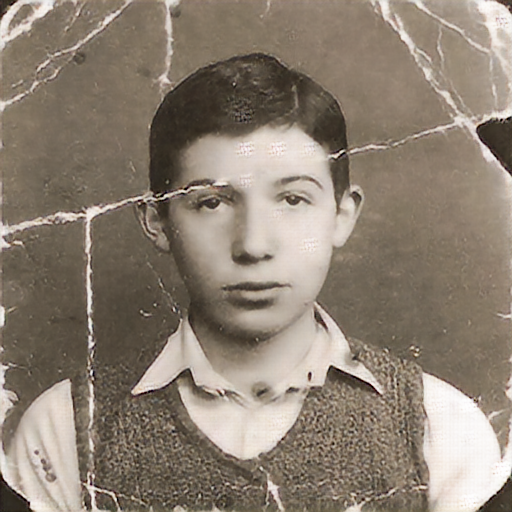

In [14]:
import requests
from io import BytesIO
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])


link = "https://pixbim.com/sites/default/files/blogpics/smith/orpicsai/scratch_removal/scratch_removal_automatic_1.jpg"
response = requests.get(link)
original_image = Image.open(BytesIO(response.content))
# original_image = test_list[0]["A"]
output_image = image_manipulation.np_to_pil(
    generator(transform(original_image).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

width, height = original_image.size
output_image.resize((width, height))
new_image = Image.new(output_image.mode, (width * 2, height))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (width, 0))

# image_manipulation.np_to_pil(transform(original_image).detach().cpu().numpy())
output_image

In [20]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [12]:
# count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
